In [1]:
import sys
sys.path.append("..")

#import datetime, time, os

import IPython
import IPython.display
#import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import seaborn as sns
import tensorflow as tf
#from tqdm import tqdm

import pickle

from sklearn.preprocessing import StandardScaler
from functions import df_security_code

import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")


In [2]:
INPUT = 24
OUT_STEPS = 24
SHIFT = 24
SAVEMODEL = True

CODE = 'all'#8198# 'all' #8198

# Data

In [3]:
data_raw = pd.read_csv('../data/curr_price_financial_fill.csv', parse_dates=['Date'], index_col=[0])
#data.dropna(inplace=True)
#df = df_security_code(data)
if isinstance(CODE, int):
    data = df_security_code(data_raw, CODE)
    codes = CODE
else: 
    data = data_raw
    codes = data.SecuritiesCode.unique()

del data_raw

select features to train the mode

In [4]:
cols = ['Date', 'SecuritiesCode', 'ExpectedDividend',
       'SupervisionFlag', 'ad_Open', 'ad_High', 'ad_Low', 'ad_Close',
       'ad_Volume', 'ad_Target', 'ad_Close_lag1', 'ad_Close_sma10',
        'ad_Open_lag1', 'ad_Open_sma10',
        'ad_High_lag1', 'ad_High_sma10',
        'ad_Low_lag1', 'ad_Low_sma10',
        'ad_Volume_lag1', 'ad_Volume_sma10', 'RSI', 'Return',
       'macd', 'macd_h', 'macd_s', 
       'Volatility_week', 'Day_sin', 'Day_cos', 'Month_sin', 'Month_cos',
       'Year_sin', 'Year_cos']
 
data = data[cols]
data.set_index('Date', inplace=True)

In [5]:
columns = data.drop(['SecuritiesCode'], axis=1).columns

## Windows and dataset preparation

create for each security code a window separator 

In [6]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train,#, train_df,#normalizer(train_df), 
               val, 
               test,
               label_columns=None):
    # Store the raw data.
    self.train_df = train
    self.val_df = val
    self.test_df = test

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    #self.example = 

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

split train, validation and test data

In [7]:
def split_train_val_test(df, split=22):
    #df.dropna(inplace=True)
    df_train =  df[:- 4*split]
    df_val = df[- 4*split : - split]
    df_test = df[- split : ]

    return df_train, df_val, df_test

create slices of the windows with inputs and values to predict

In [8]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

function to plot windows dataset

In [9]:
def plot(self, model=None, plot_col='ad_Close', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model.predict(inputs) # add predict
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

create a time series data set based on slices of the windows 
to fit a tensorflow model

In [10]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

plot loss history of the trained model

In [11]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    #plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

plot the metric RMSE history during training 

In [12]:
# Plotting function for MSE
def plot_metric(history):
    plt.plot(history.history['root_mean_squared_error'])
    plt.plot(history.history['val_root_mean_squared_error'])
    plt.title('Model RMSE')
    plt.ylabel('RMSE')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

In [13]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

@property
def separe_map_train(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result



WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example



initialize variables

In [14]:
length = 0
num_features = None

create a window object based on one security code

In [15]:
# select one window
def select_one(data, code):
    # select one security
    df= df_security_code(data, code)
    df.drop(['SecuritiesCode'], axis = 1, inplace=True)
    # split train, val test
    train, val, test = split_train_val_test(df, split=22)
    global length 
    length = length + len(train) 
    # scale the data
    scaler = StandardScaler()
    scaler.fit(train)
    train_scaled = scaler.transform(train)
    val_scaled = scaler.transform(val)
    test_scaled = scaler.transform(test)
    
    # save the scaler
    name_scaler = f'../models/ann/scaler/{code}_scaler.sav'
    pickle.dump(scaler, open(name_scaler, 'wb'))

    global num_features
    num_features = train_scaled.shape[1]
    
    window_curr = WindowGenerator(
                                input_width=INPUT, 
                               label_width=OUT_STEPS,
                               shift=SHIFT,
                               train = train_scaled,
                               val=val_scaled,
                               test=test_scaled)


    return window_curr

after initalization of the first dataset
new codes can be added to the dataset. 
this ensures the proper preprocessing for each code 

In [16]:
def add_codes(data, codes):
    for code in codes:
        if code == 8198: continue
        multi_window = select_one(data, code)

        train_ds.concatenate(multi_window.train)
        val_ds.concatenate(multi_window.val)
        test_ds.concatenate(multi_window.test)
    pass

Make dataset with all codes:

In [17]:
type(codes)

numpy.ndarray

In [18]:

# initialize dataset
window_one = select_one(data, 8198)
# separe them into train, val and test 
train_ds = window_one.train
val_ds = window_one.val
test_ds = window_one.test

# add codes:
if isinstance(codes, np.ndarray):
    # starting window
    multi_window = window_one
    # add datasets
    add_codes(data, codes)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-05-11 19:58:57.147808: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-11 19:58:57.147922: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Preparation to fit the model

In [19]:
MAX_EPOCHS = 20
MAX_EPOCHS = 100
BATCH_SIZE = 32

N_TRAIN = length
STEPS_PER_EPOCH = N_TRAIN // BATCH_SIZE


def compile_and_fit(model, window, patience=3):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min'
                                                    )

  lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.01,
    decay_steps=STEPS_PER_EPOCH*1000,
    decay_rate=1,
    staircase=False)  
    
  opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule, name='Adam')

  model.compile(loss='mae', 
                optimizer=opt,
                metrics= [tf.keras.metrics.RootMeanSquaredError()]),

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks = [early_stopping]
                      )
  return history

# Train Models

## - Baseline

baselinemode performance baseline as a point for comparison with the later more complicated models
baseline predict value is the value before

2022-05-11 20:01:32.774714: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-11 20:01:32.831533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 220ms/step - loss: 0.2446 - mean_absolute_error: 0.2304


2022-05-11 20:01:33.276792: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


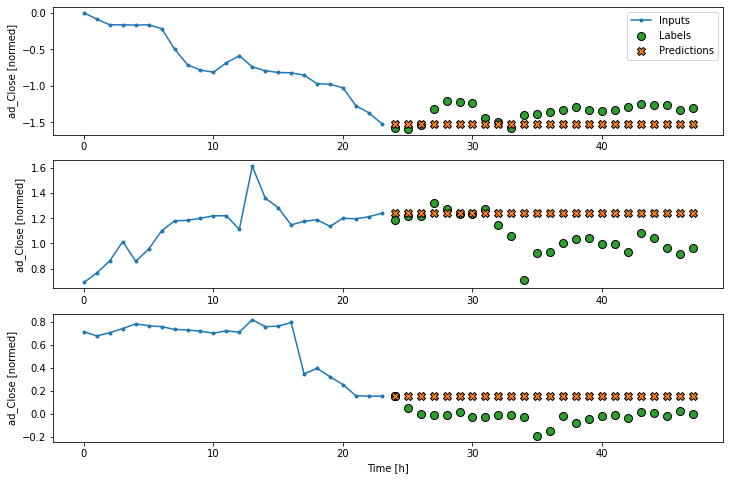

In [20]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}


multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)

multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

In [21]:
if SAVEMODEL == True:
    last_baseline.save('../models/ann/baseline')

INFO:tensorflow:Assets written to: ../models/ann/baseline/assets


2022-05-11 20:01:33.574937: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


## - Baseline 2


another simple approach is to repeat the previous day, assuming tomorrow will be similar

2022-05-11 20:01:33.769137: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 69ms/step - loss: 0.2359 - mean_absolute_error: 0.2806


2022-05-11 20:01:33.863415: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


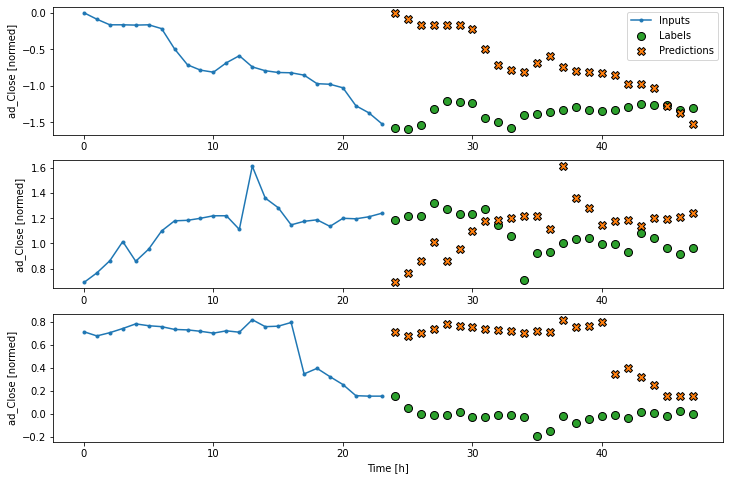

In [22]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)

multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

In [23]:
if SAVEMODEL == True:
    repeat_baseline.save('../models/ann/baseline2')

INFO:tensorflow:Assets written to: ../models/ann/baseline2/assets


## - Linear
A simple linear model based on the last input time step does better than either baseline, but is underpowered. The model needs to predict OUTPUT_STEPS time steps, from a single input time step with a linear projection. It can only capture a low-dimensional slice of the behavior, likely based mainly on the time of day and time of year.

1/1 [==============================] - 0s 22ms/step - loss: 0.2683 - root_mean_squared_error: 0.4670


2022-05-11 20:01:35.799822: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


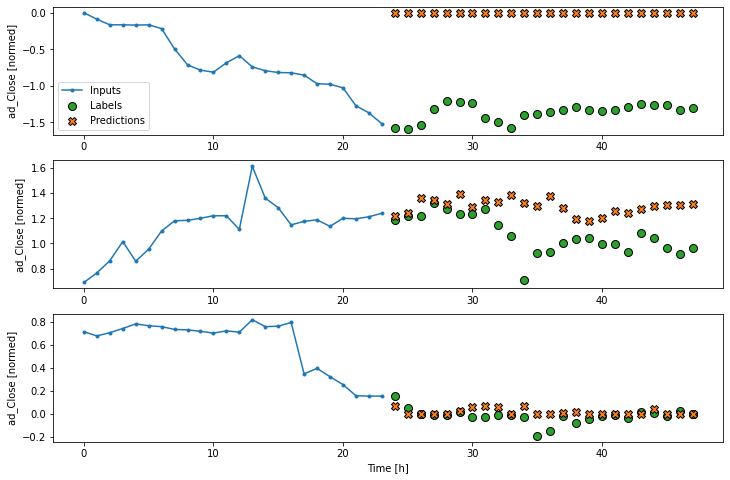

In [24]:
multi_linear_model = tf.keras.Sequential([

    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),

    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer='uniform', 
                          activation='relu'),

    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])
with tf.device('/cpu:0'):
    history = compile_and_fit(multi_linear_model, multi_window)


    IPython.display.clear_output()

    multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
    multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
    multi_window.plot(multi_linear_model)

In [25]:
if SAVEMODEL == True:
    multi_linear_model.save('../models/ann/linear')

INFO:tensorflow:Assets written to: ../models/ann/linear/assets


In [26]:
multi_linear_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 1, 30)             0         
                                                                 
 dense (Dense)               (None, 1, 720)            22320     
                                                                 
 reshape (Reshape)           (None, 24, 30)            0         
                                                                 
Total params: 22,320
Trainable params: 22,320
Non-trainable params: 0
_________________________________________________________________


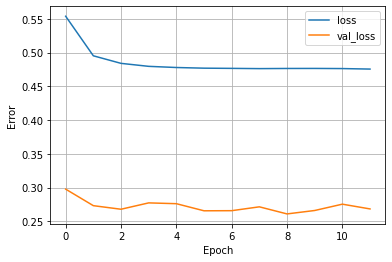

In [27]:
plot_loss(history)

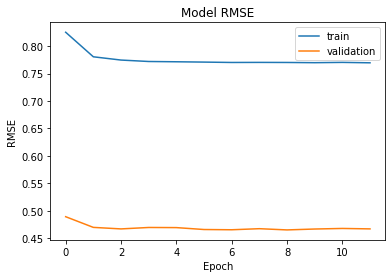

In [28]:
plot_metric(history)

## - Dense

1/1 [==============================] - 0s 21ms/step - loss: 0.1896 - root_mean_squared_error: 0.3189


2022-05-11 20:01:38.523289: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


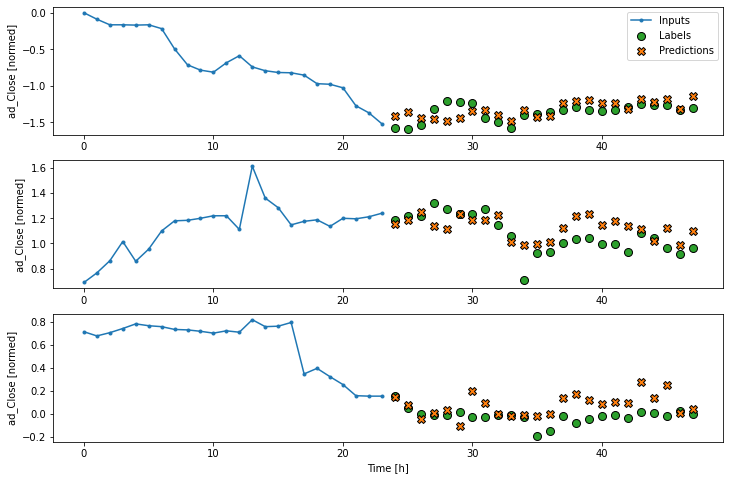

In [29]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    #tf.keras.layers.Normalization(axis=-1),   # including normalization
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer='uniform'),#tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])
with tf.device('/cpu:0'):
    history = compile_and_fit(multi_dense_model, multi_window)

    #inputs, labels = multi_window.separe_map
    IPython.display.clear_output()
    multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
    multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
    multi_window.plot(multi_dense_model)

In [30]:
if SAVEMODEL == True:
    multi_dense_model.save('../models/ann/dense')

INFO:tensorflow:Assets written to: ../models/ann/dense/assets


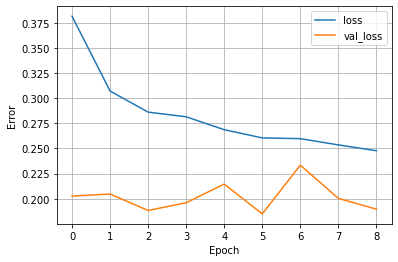

In [31]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
#plt.ylim([0, 10])
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.grid(True)

## - CONV

1/1 [==============================] - 0s 24ms/step - loss: 0.2280 - root_mean_squared_error: 0.3359


2022-05-11 20:01:40.700497: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


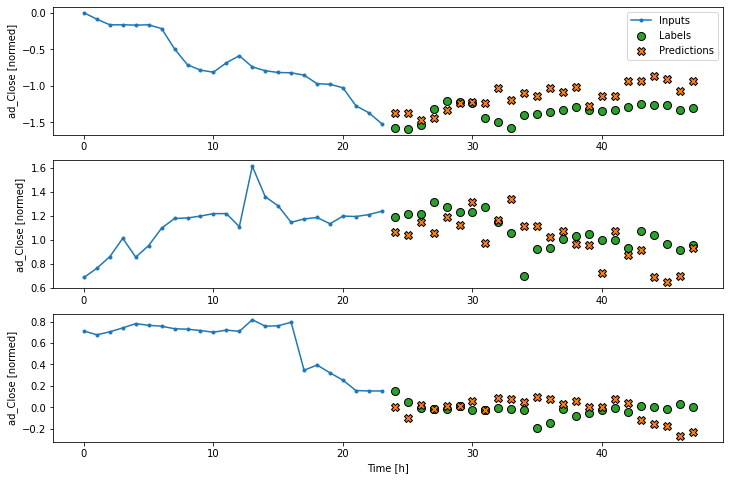

In [32]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    #tf.keras.layers.Normalization(axis=-1),   # including normalization
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer='uniform'),#tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])
with tf.device('/cpu:0'):
    history = compile_and_fit(multi_conv_model, multi_window)

    IPython.display.clear_output()
    #inputs, labels = multi_window.separe_map
    multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
    multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
    multi_window.plot(multi_conv_model)

In [33]:
if SAVEMODEL == True:
    multi_conv_model.save('saved_model/conv')

INFO:tensorflow:Assets written to: saved_model/conv/assets


In [34]:
multi_conv_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_2 (Lambda)           (None, 3, 30)             0         
                                                                 
 conv1d (Conv1D)             (None, 1, 256)            23296     
                                                                 
 dense_3 (Dense)             (None, 1, 720)            185040    
                                                                 
 reshape_2 (Reshape)         (None, 24, 30)            0         
                                                                 
Total params: 208,336
Trainable params: 208,336
Non-trainable params: 0
_________________________________________________________________


In [35]:
hist = pd.DataFrame(history.history)

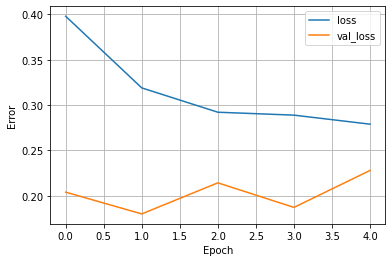

In [36]:
plot_loss(history)

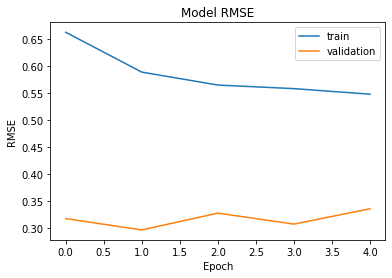

In [37]:
plot_metric(history)

## -lstm

1/1 [==============================] - 0s 21ms/step - loss: 0.3630 - root_mean_squared_error: 0.5205


2022-05-11 20:01:43.145178: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


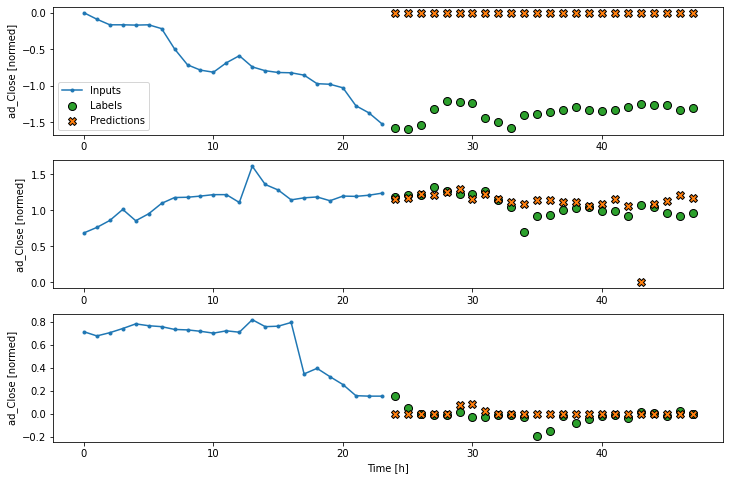

In [38]:
multi_lstm_model = tf.keras.Sequential([

    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]), #new
    tf.keras.layers.LSTM(32, return_sequences=False, activation='relu'),
    

    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer='uniform', 
                        activation='relu'),

    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])
with tf.device('/cpu:0'):
    history = compile_and_fit(multi_lstm_model, multi_window)

    IPython.display.clear_output()

    multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
    multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
    multi_window.plot(multi_lstm_model)

In [39]:
if SAVEMODEL == True:
    multi_lstm_model.save('../models/ann/lstm')

INFO:tensorflow:Assets written to: ../models/ann/lstm/assets


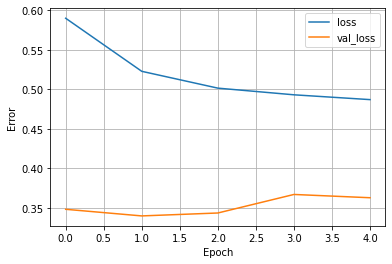

In [40]:
plot_loss(history)

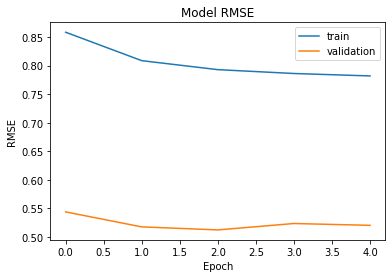

In [41]:
plot_metric(history)

## - FeedBack


In [42]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
        #tf.keras.layers.Lambda(lambda x: x[:, -1:, :]), #new
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [43]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [44]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)

  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup


In [45]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 30])

In [46]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

Epoch 1/100


2022-05-11 20:01:46.829684: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


34/34 [==============================] - 3s 34ms/step - loss: nan - root_mean_squared_error: nan - val_loss: nan - val_root_mean_squared_error: nan
Epoch 2/100
 4/34 [==>...........................] - ETA: 0s - loss: nan - root_mean_squared_error: nan

2022-05-11 20:01:48.257888: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


34/34 [==============================] - 1s 20ms/step - loss: nan - root_mean_squared_error: nan - val_loss: nan - val_root_mean_squared_error: nan
Epoch 3/100
1/1 [==============================] - 0s 29ms/step - loss: nan - root_mean_squared_error: nan


2022-05-11 20:01:49.983900: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


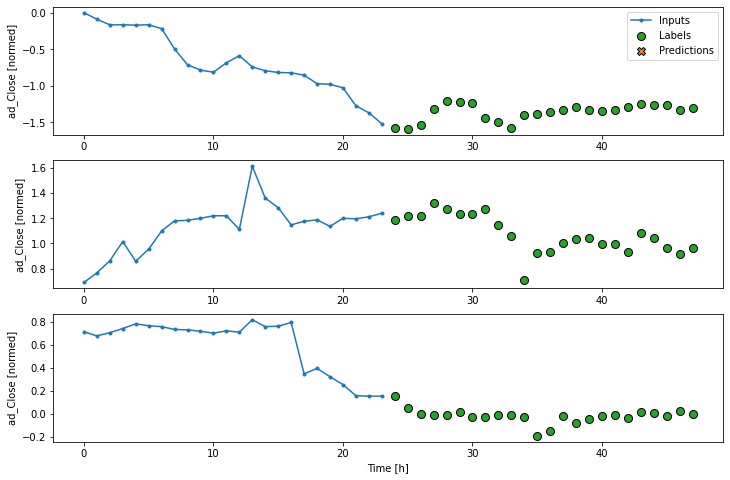

In [47]:
with tf.device('/cpu:0'):
    history = compile_and_fit(feedback_model, multi_window)

    #IPython.display.clear_output()

    multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
    multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
    multi_window.plot(feedback_model)

In [48]:
if SAVEMODEL == True:
    feedback_model.save('saved_model/24_feedback_ds')

INFO:tensorflow:Assets written to: saved_model/24_feedback_ds/assets


INFO:tensorflow:Assets written to: saved_model/24_feedback_ds/assets


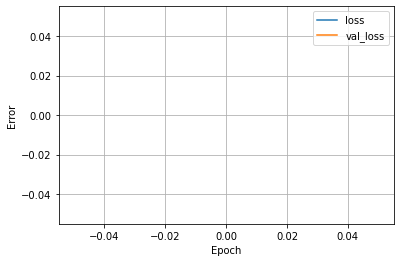

In [49]:
plot_loss(history)

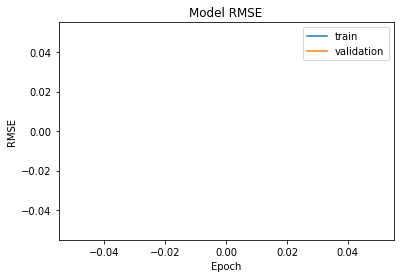

In [50]:
plot_metric(history)

Model Performance


In [51]:

pd.DataFrame(multi_val_performance, index=['Mean Squared Error [ad_Close]', 'Mean Absolute error [ad_Close]'] ).T


,Mean Squared Error [ad_Close],Mean Absolute error [ad_Close]
Last,0.244643,0.230440
Repeat,0.235850,0.280628
Linear,0.268296,0.467020
Dense,0.189588,0.318894
Conv,0.227977,0.335907
LSTM,0.362981,0.520489
AR LSTM,NaN,NaN
